In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
from skimage import color
import itertools as it
import math

import sys
sys.path.append("..")
from src import hierarchic_blending_operator
from src import color_converter
from src import color_operations
from src import color_schemes
from src import picture_worker
from src import helper

In [2]:
def generate_weights(z_values):
    z_sum = z_values[0].copy()
    z_min, z_max = np.min(z_values[0]), np.max(z_values[1])
    for i in z_values:
        i_min = np.min(i)
        i_max = np.max(i)
        z_min = np.min([z_min,i_min])
        z_max = np.max([z_max,i_max])
        z_sum += i
    return z_min, z_max, z_sum

In [3]:
def generate_gaussians(gaussians):
    return [helper.get_gaussian(*gaussian)[2] for gaussian in gaussians]

In [4]:
def generate_image(gaussians, colorschemes, blending_operator = hierarchic_blending_operator.porter_duff_source_over, borders = [0, 1], levels = 10, split = False, contour_lines = True,  verbose=False):
    print(gaussians[1])
    z_list = generate_gaussians(gaussians)
    z_min, z_max, z_sum = generate_weights(z_list)
    img_list = []
    lower_border = borders[0]
    upper_border = borders[1]
    for z, colorscheme in zip(z_list, colorschemes):
        z_min_weight = (upper_border-lower_border)*(np.min(z) - z_min) / (z_max - z_min)+lower_border
        z_max_weight = (upper_border-lower_border)*(np.max(z) - z_min) / (z_max - z_min)+lower_border
        img, _ = picture_worker.get_colorgrid(z, **colorscheme ,min_value = z_min_weight, max_value = z_max_weight, split = False, verbose = verbose)
        img_list.append(img)
    image, alpha = picture_worker.combine_multiple_images_hierarchic(hierarchic_blending_operator.porter_duff_source_over, img_list, z_list)
    if contour_lines:
        image = picture_worker.find_contour_lines(z_sum, image, 7)
    return image

In [62]:
def plot_images(images, gaussians):
    print("{}".format(["mu_x", "variance_x", "mu_y", "variance_y"]))
    if len(images) == 1:
        plt.imshow(images[0])
        plt.axis("off")
    else:
        for i in range(math.ceil(len(images)/5)):
            subplot = images[i*5:(i+1)*5]
            fig, axes = plt.subplots(1,len(subplot))
            for j in range(len(subplot)):
                axes[j].imshow(subplot[j])       
                axes[j].set_title('\n'.join("{}".format(gau[4:-1]) for gau in gaussians[j]))
                axes[j].axis("off")
            plt.subplots_adjust(bottom=0.0, left=0, right=2, top=2)

## Zwei Gaussians
Einer statisch, einer bewegt sich in jeder möglichen Richtung

In [6]:
size = 400

### Statischer Gaussian

In [7]:
x_min, x_max = -10, 10
y_min, y_max = -10, 10
mu_x, mu_y = 2,2
variance_x, variance_y = 5,5

In [8]:
gaussian_static = [x_min, x_max, y_min, y_max, mu_x, variance_x, mu_y, variance_y, size]

In [77]:
colorscheme_generator = color_schemes.create_color_brewer_colorscheme
colorscheme_names = ["red", "purple", "green", "orange", "blue'"]

In [78]:
colorschemes = [{"color_scheme": colorscheme_generator, "colorscheme": colorscheme_name} for colorscheme_name in colorscheme_names]

In [11]:
gaussians_2d = []
for mu_x, variance_x, mu_y, variance_y in it.permutations([-5, -2, 0, 2, 5, 10, 15],4):
    if not (variance_x < 0 or variance_y < 0 or variance_x == 0 or variance_y == 0) and not (mu_x > 4 or mu_y > 4) and not(mu_x < -2 or mu_y < -2):
        gaussians_2d.append([x_min, x_max, y_min, y_max, mu_x, variance_x, mu_y, variance_y, size])

In [12]:
# gaussians_moving_one_parameter = [ for i in range(x_min, x_max)]
len(gaussians_2d)

48

In [13]:
images_up_down = []
for i in gaussians_2d:
    images_up_down.append(generate_image([gaussian_static, i], colorschemes))

[-10, 10, -10, 10, -2, 2, 0, 5, 400]
[-10, 10, -10, 10, -2, 2, 0, 10, 400]
[-10, 10, -10, 10, -2, 2, 0, 15, 400]
[-10, 10, -10, 10, -2, 5, 0, 2, 400]
[-10, 10, -10, 10, -2, 5, 0, 10, 400]
[-10, 10, -10, 10, -2, 5, 0, 15, 400]
[-10, 10, -10, 10, -2, 5, 2, 10, 400]
[-10, 10, -10, 10, -2, 5, 2, 15, 400]
[-10, 10, -10, 10, -2, 10, 0, 2, 400]
[-10, 10, -10, 10, -2, 10, 0, 5, 400]
[-10, 10, -10, 10, -2, 10, 0, 15, 400]
[-10, 10, -10, 10, -2, 10, 2, 5, 400]
[-10, 10, -10, 10, -2, 10, 2, 15, 400]
[-10, 10, -10, 10, -2, 15, 0, 2, 400]
[-10, 10, -10, 10, -2, 15, 0, 5, 400]
[-10, 10, -10, 10, -2, 15, 0, 10, 400]
[-10, 10, -10, 10, -2, 15, 2, 5, 400]
[-10, 10, -10, 10, -2, 15, 2, 10, 400]
[-10, 10, -10, 10, 0, 2, -2, 5, 400]
[-10, 10, -10, 10, 0, 2, -2, 10, 400]
[-10, 10, -10, 10, 0, 2, -2, 15, 400]
[-10, 10, -10, 10, 0, 5, -2, 2, 400]
[-10, 10, -10, 10, 0, 5, -2, 10, 400]
[-10, 10, -10, 10, 0, 5, -2, 15, 400]
[-10, 10, -10, 10, 0, 5, 2, 10, 400]
[-10, 10, -10, 10, 0, 5, 2, 15, 400]
[-10, 10, -10,

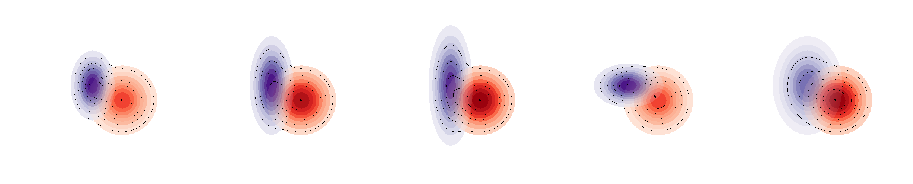

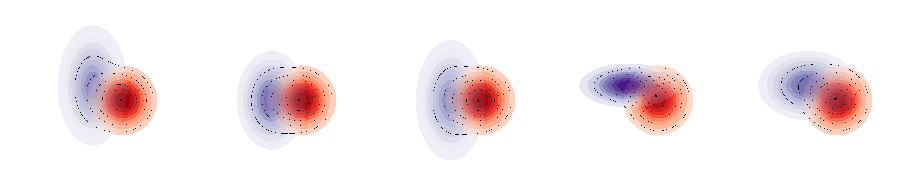

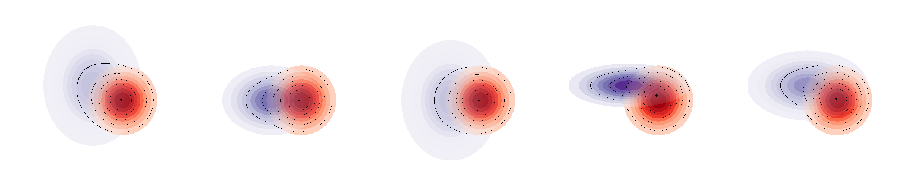

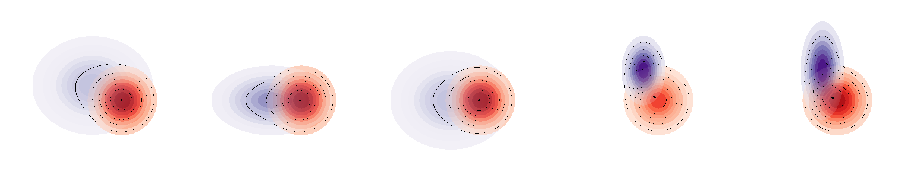

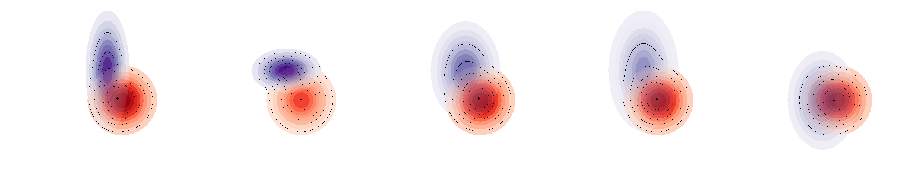

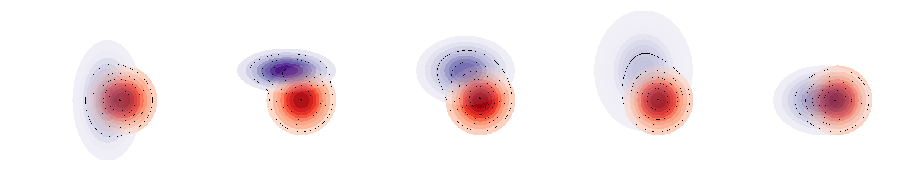

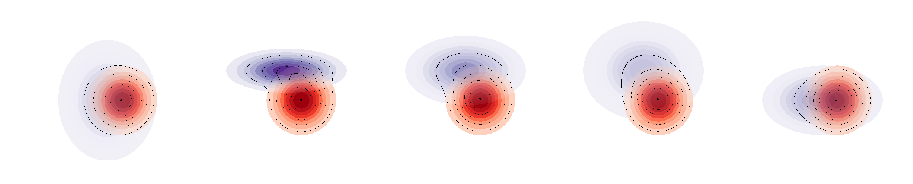

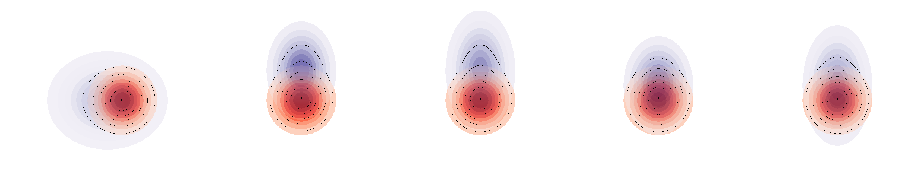

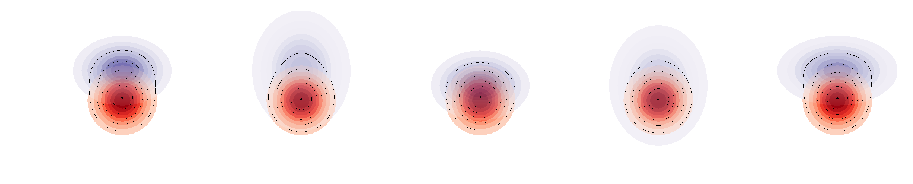

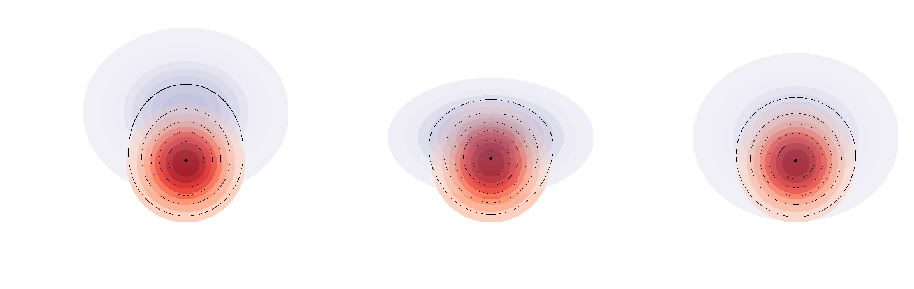

In [28]:
plot_images(images_up_down)

## Drei Gaussians
Einer statisch, zwei bewegen sich

In [29]:
gaussians_3 = []
for i,j in it.combinations(range(len(gaussians_2d)),2):
    gaussians_3.append([gaussian_static, gaussians_2d[i], gaussians_2d[j]])

In [30]:
images_3 = []
for i in np.linspace(0,len(gaussians_3)-1,dtype=int):
    images_3.append(generate_image(gaussians_3[i], colorschemes))

[-10, 10, -10, 10, -2, 2, 0, 5, 400]
[-10, 10, -10, 10, -2, 2, 0, 5, 400]
[-10, 10, -10, 10, -2, 2, 0, 5, 400]
[-10, 10, -10, 10, -2, 2, 0, 10, 400]
[-10, 10, -10, 10, -2, 2, 0, 10, 400]
[-10, 10, -10, 10, -2, 2, 0, 15, 400]
[-10, 10, -10, 10, -2, 5, 0, 2, 400]
[-10, 10, -10, 10, -2, 5, 0, 2, 400]
[-10, 10, -10, 10, -2, 5, 0, 10, 400]
[-10, 10, -10, 10, -2, 5, 0, 10, 400]
[-10, 10, -10, 10, -2, 5, 0, 15, 400]
[-10, 10, -10, 10, -2, 5, 0, 15, 400]
[-10, 10, -10, 10, -2, 5, 2, 10, 400]
[-10, 10, -10, 10, -2, 5, 2, 10, 400]
[-10, 10, -10, 10, -2, 5, 2, 15, 400]
[-10, 10, -10, 10, -2, 5, 2, 15, 400]
[-10, 10, -10, 10, -2, 10, 0, 2, 400]
[-10, 10, -10, 10, -2, 10, 0, 5, 400]
[-10, 10, -10, 10, -2, 10, 0, 5, 400]
[-10, 10, -10, 10, -2, 10, 0, 15, 400]
[-10, 10, -10, 10, -2, 10, 0, 15, 400]
[-10, 10, -10, 10, -2, 10, 2, 5, 400]
[-10, 10, -10, 10, -2, 10, 2, 15, 400]
[-10, 10, -10, 10, -2, 10, 2, 15, 400]
[-10, 10, -10, 10, -2, 15, 0, 2, 400]
[-10, 10, -10, 10, -2, 15, 0, 5, 400]
[-10, 10, -10

['mu_x', 'variance_x', 'mu_y', 'variance_y']


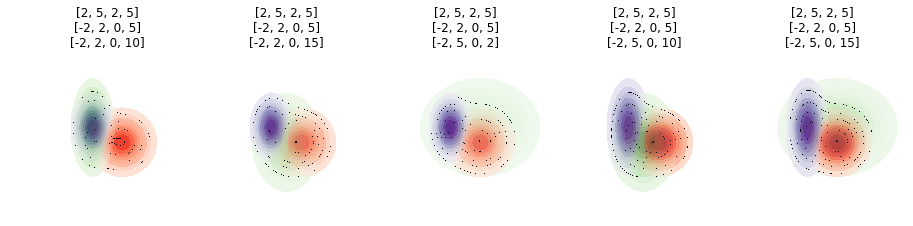

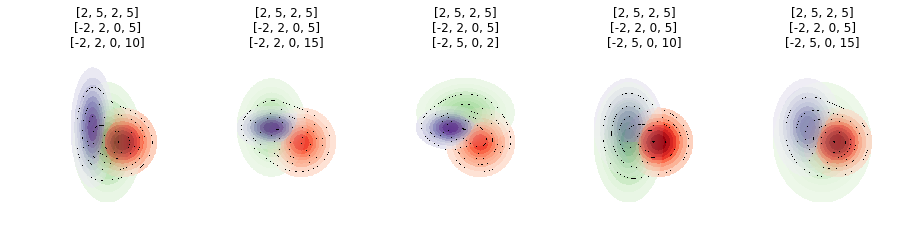

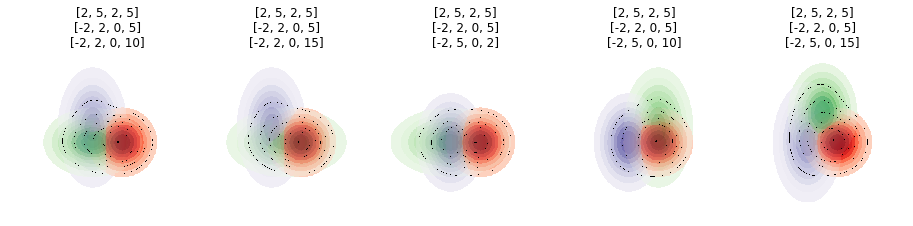

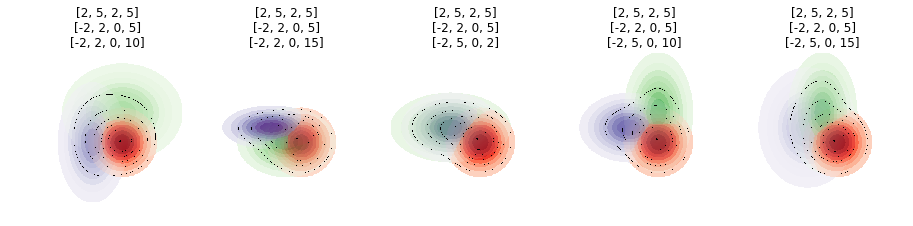

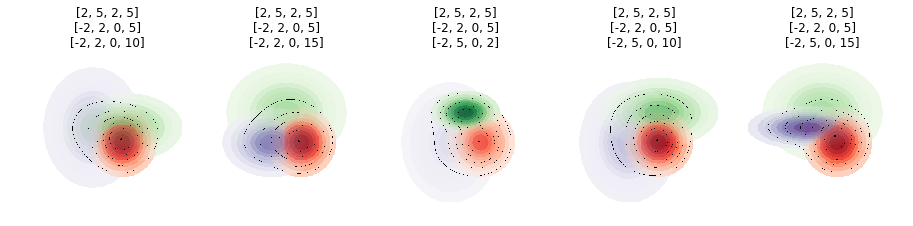

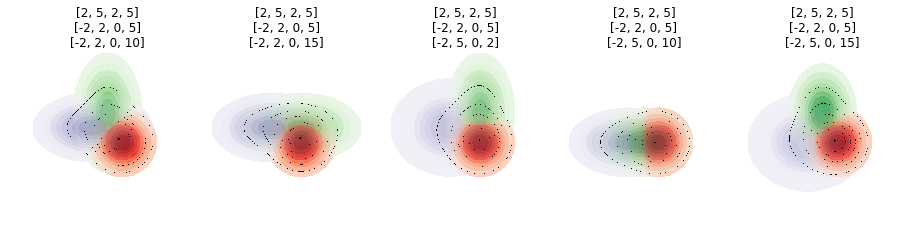

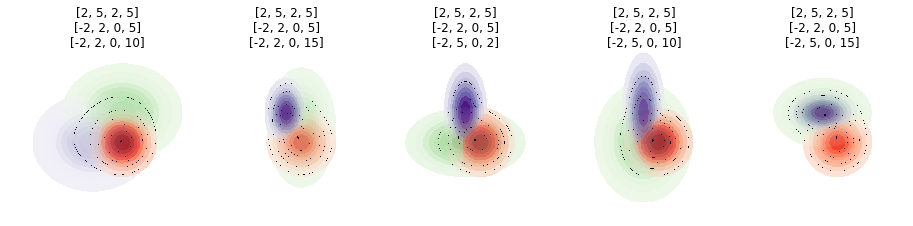

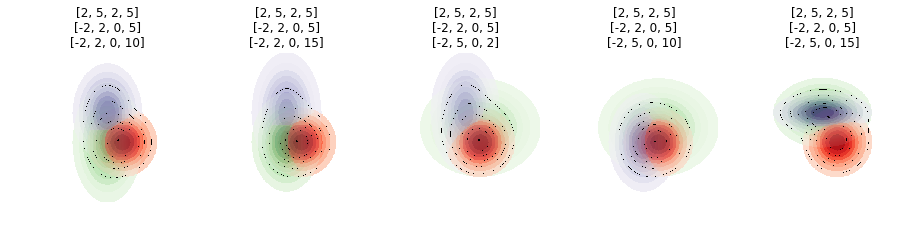

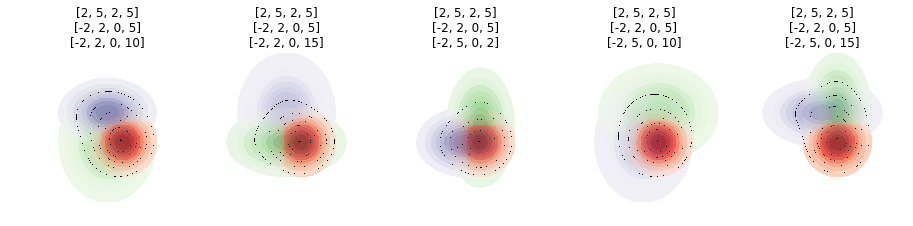

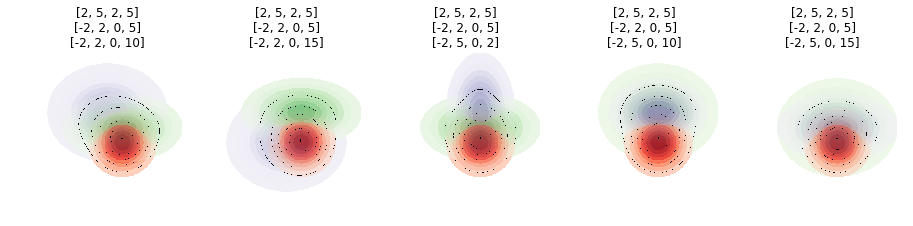

In [63]:
plot_images(images_3, gaussians_3)

## Vier Gaussians
Einer Statisch, drei bewegen sich

In [64]:
gaussians_4 = []
for i,j,k in it.combinations(range(len(gaussians_2d)),3):
    gaussians_4.append([gaussian_static, gaussians_2d[i], gaussians_2d[j], gaussians_2d[k]])

In [66]:
images_4 = []
for i in np.linspace(0,len(gaussians_4)-1,dtype=int):
    images_4.append(generate_image(gaussians_4[i], colorschemes))

[-10, 10, -10, 10, -2, 2, 0, 5, 400]
[-10, 10, -10, 10, -2, 2, 0, 5, 400]
[-10, 10, -10, 10, -2, 2, 0, 5, 400]
[-10, 10, -10, 10, -2, 2, 0, 5, 400]
[-10, 10, -10, 10, -2, 2, 0, 10, 400]
[-10, 10, -10, 10, -2, 2, 0, 10, 400]
[-10, 10, -10, 10, -2, 2, 0, 15, 400]
[-10, 10, -10, 10, -2, 2, 0, 15, 400]
[-10, 10, -10, 10, -2, 2, 0, 15, 400]
[-10, 10, -10, 10, -2, 5, 0, 2, 400]
[-10, 10, -10, 10, -2, 5, 0, 2, 400]
[-10, 10, -10, 10, -2, 5, 0, 2, 400]
[-10, 10, -10, 10, -2, 5, 0, 10, 400]
[-10, 10, -10, 10, -2, 5, 0, 10, 400]
[-10, 10, -10, 10, -2, 5, 0, 10, 400]
[-10, 10, -10, 10, -2, 5, 0, 15, 400]
[-10, 10, -10, 10, -2, 5, 0, 15, 400]
[-10, 10, -10, 10, -2, 5, 2, 10, 400]
[-10, 10, -10, 10, -2, 5, 2, 10, 400]
[-10, 10, -10, 10, -2, 5, 2, 15, 400]
[-10, 10, -10, 10, -2, 5, 2, 15, 400]
[-10, 10, -10, 10, -2, 5, 2, 15, 400]
[-10, 10, -10, 10, -2, 10, 0, 2, 400]
[-10, 10, -10, 10, -2, 10, 0, 2, 400]
[-10, 10, -10, 10, -2, 10, 0, 5, 400]
[-10, 10, -10, 10, -2, 10, 0, 5, 400]
[-10, 10, -10, 10, 

['mu_x', 'variance_x', 'mu_y', 'variance_y']


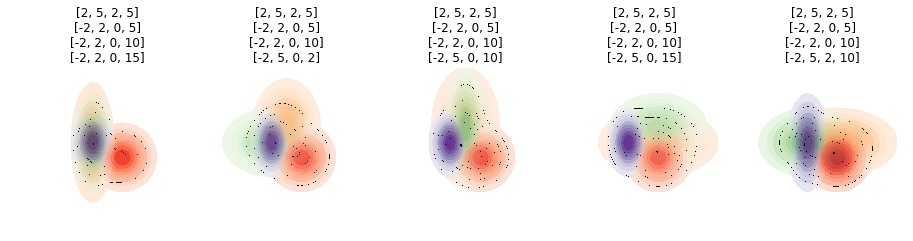

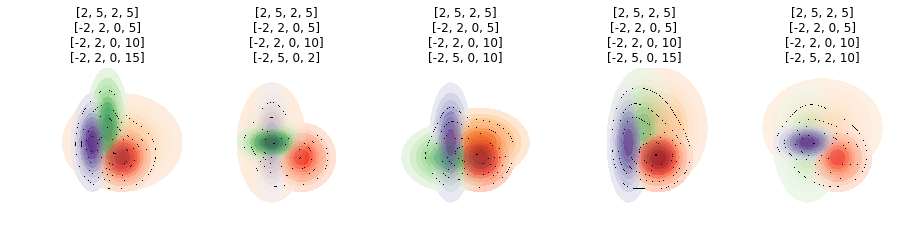

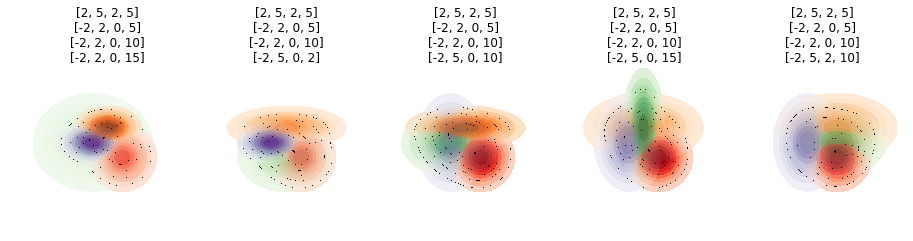

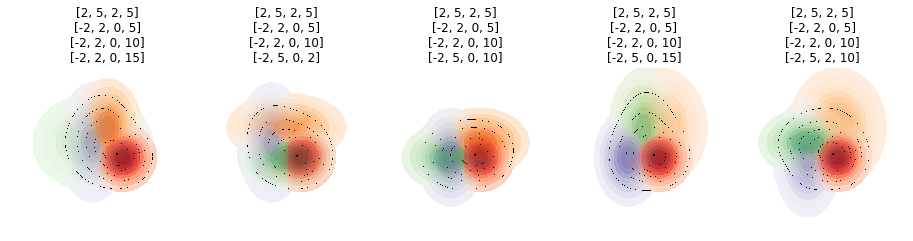

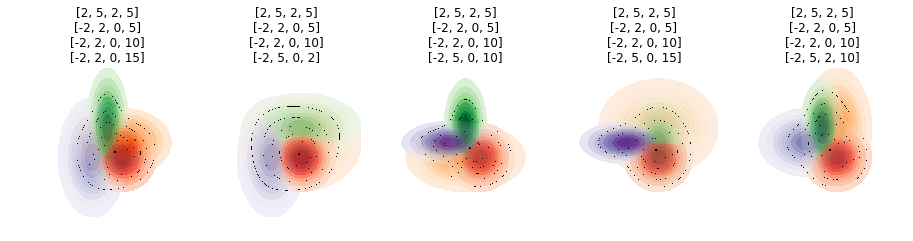

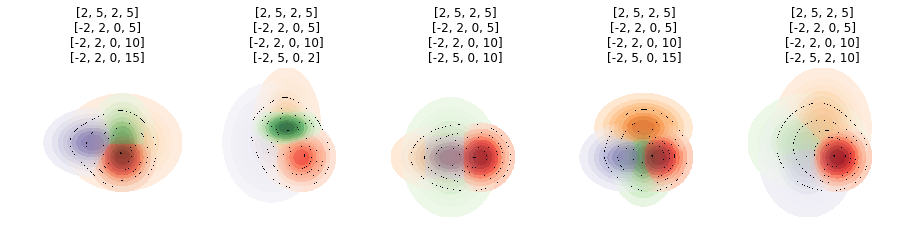

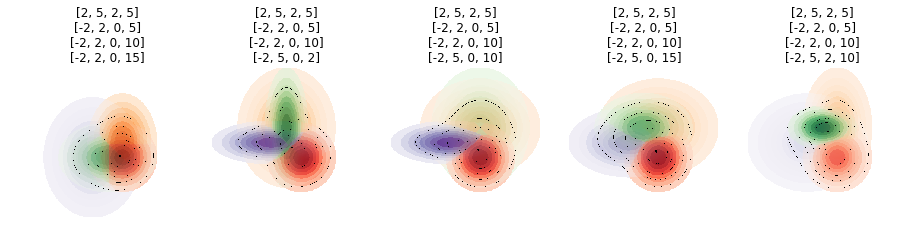

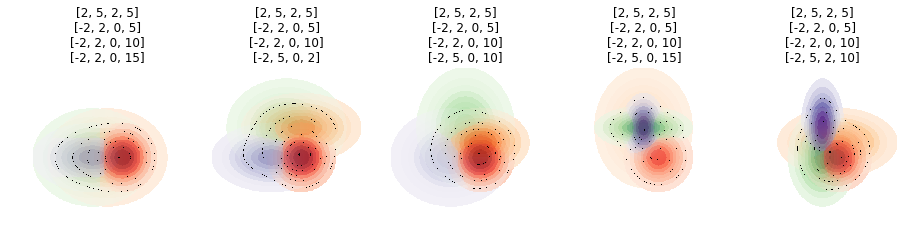

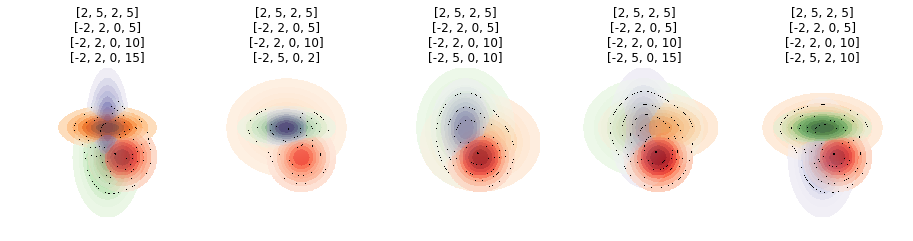

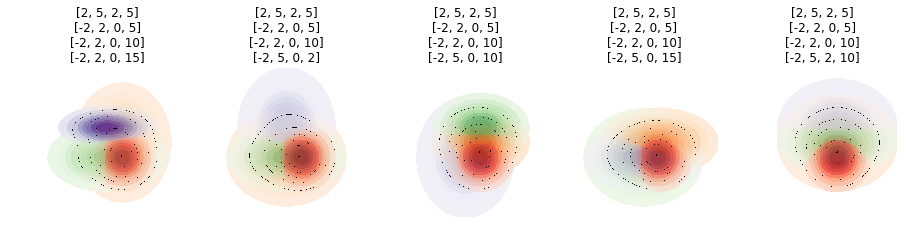

In [67]:
plot_images(images_4, gaussians_4)

In [79]:
gaussians_5 = []
for i,j,k,l in it.combinations(range(len(gaussians_2d)),4):
    gaussians_5.append([gaussian_static, gaussians_2d[i], gaussians_2d[j], gaussians_2d[k], gaussians_2d[l]])

In [80]:
len(gaussians_5)

194580

In [81]:
images_5 = []
for i in np.linspace(0,len(gaussians_5)-1,dtype=int):
    images_5.append(generate_image(gaussians_5[i], colorschemes))

0
[-10, 10, -10, 10, -2, 2, 0, 5, 400]
3971
[-10, 10, -10, 10, -2, 2, 0, 5, 400]
7942
[-10, 10, -10, 10, -2, 2, 0, 5, 400]
11913
[-10, 10, -10, 10, -2, 2, 0, 5, 400]
15884
[-10, 10, -10, 10, -2, 2, 0, 5, 400]
19855
[-10, 10, -10, 10, -2, 2, 0, 10, 400]
23826
[-10, 10, -10, 10, -2, 2, 0, 10, 400]
27797
[-10, 10, -10, 10, -2, 2, 0, 10, 400]
31768
[-10, 10, -10, 10, -2, 2, 0, 15, 400]
35739
[-10, 10, -10, 10, -2, 2, 0, 15, 400]
39710
[-10, 10, -10, 10, -2, 2, 0, 15, 400]
43681
[-10, 10, -10, 10, -2, 2, 0, 15, 400]
47652
[-10, 10, -10, 10, -2, 5, 0, 2, 400]
51623
[-10, 10, -10, 10, -2, 5, 0, 2, 400]
55594
[-10, 10, -10, 10, -2, 5, 0, 2, 400]
59565
[-10, 10, -10, 10, -2, 5, 0, 10, 400]
63536
[-10, 10, -10, 10, -2, 5, 0, 10, 400]
67507
[-10, 10, -10, 10, -2, 5, 0, 10, 400]
71478
[-10, 10, -10, 10, -2, 5, 0, 15, 400]
75449
[-10, 10, -10, 10, -2, 5, 0, 15, 400]
79420
[-10, 10, -10, 10, -2, 5, 0, 15, 400]
83391
[-10, 10, -10, 10, -2, 5, 2, 10, 400]
87362
[-10, 10, -10, 10, -2, 5, 2, 10, 400]
91

['mu_x', 'variance_x', 'mu_y', 'variance_y']


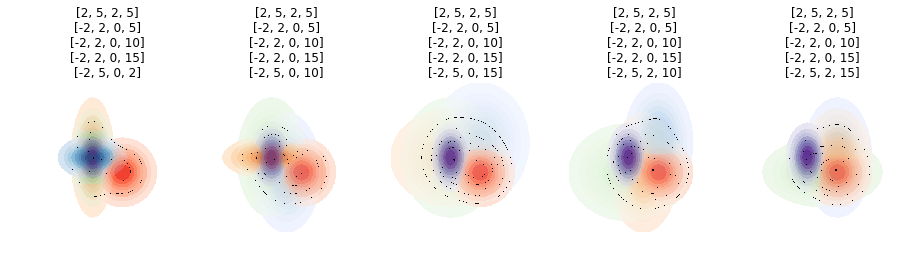

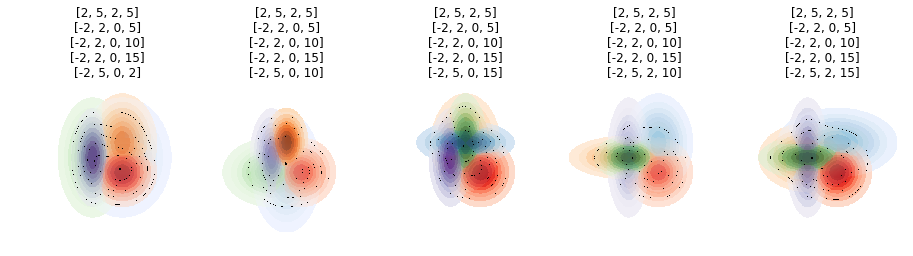

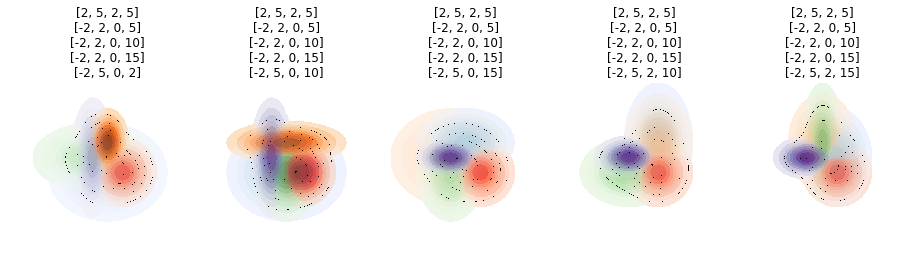

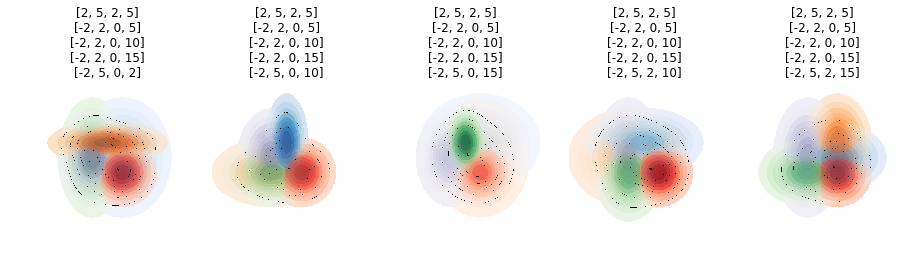

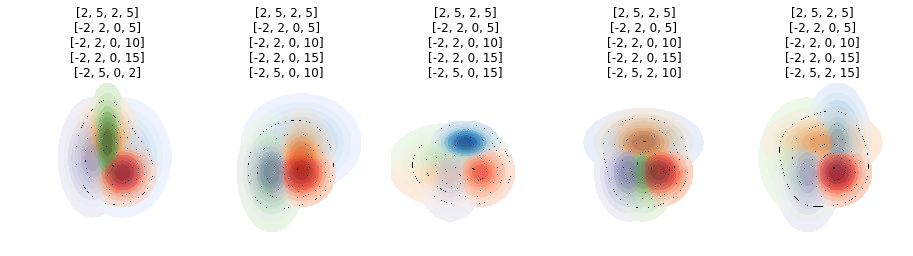

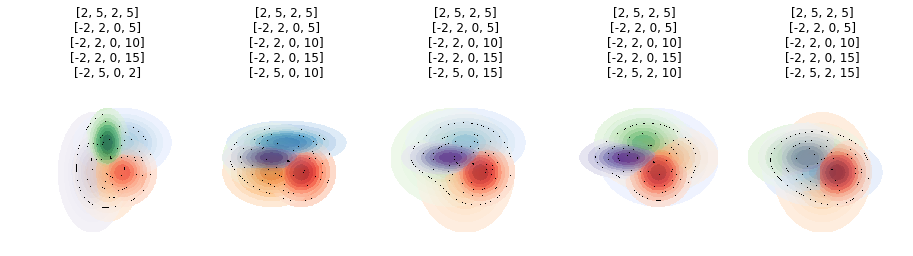

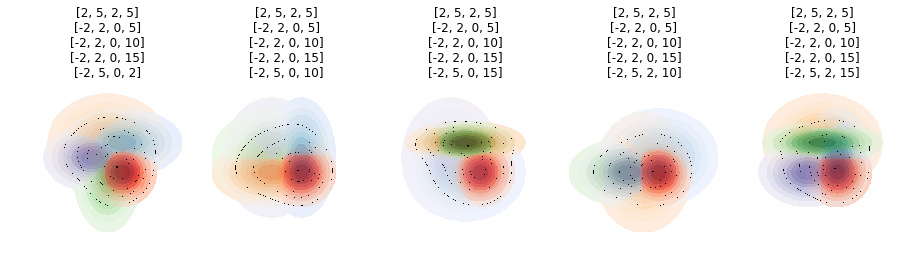

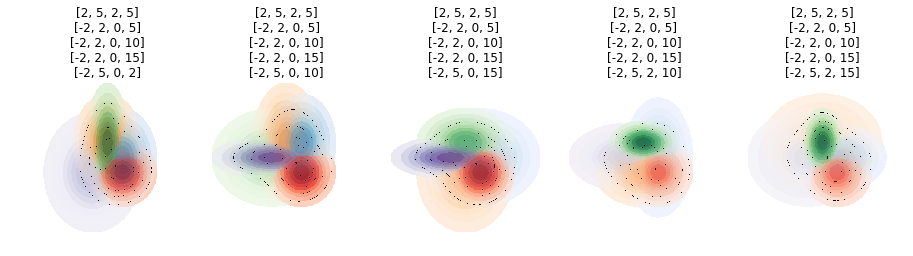

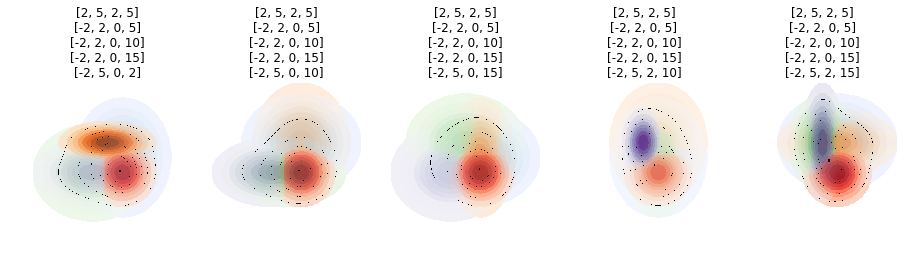

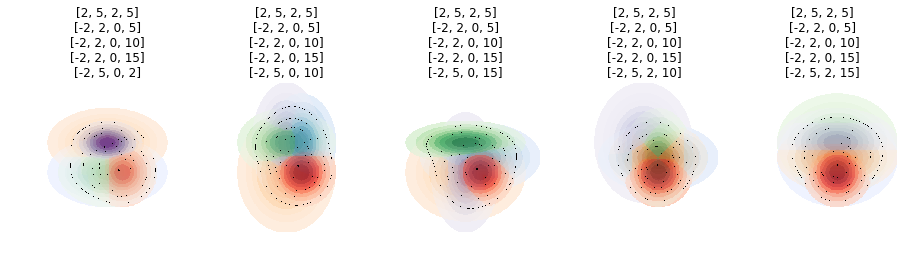

In [82]:
plot_images(images_5, gaussians_5)